In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, labels=next_states_labels)
    eloss = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1))
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    eloss += -tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # maximize loss
    aloss2_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    aloss2 = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    #rewards__ = tf.square(e_next_states_logits - next_states) 
    next_states_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                               labels=next_states_labels)
    rewards_in = tf.reduce_mean(tf.reduce_sum(next_states_loss, axis=1))
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    # eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    # aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2, rewards_in

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2, self.rewards_in = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            #rewards_in = sess.run(model.rewards_in, feed_dict)
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], feed_dict)
            #print('rewards_in.mean():', rewards_in.mean())
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:18.0000 R:18.0000 rate:0.0360 aloss:0.6969 eloss:2.0257 aloss2:3.3854 exploreP:0.9982
Episode:1 meanR:19.5000 R:21.0000 rate:0.0420 aloss:0.6944 eloss:2.0273 aloss2:3.3909 exploreP:0.9961
Episode:2 meanR:20.6667 R:23.0000 rate:0.0460 aloss:0.6969 eloss:2.0604 aloss2:3.3875 exploreP:0.9939
Episode:3 meanR:22.5000 R:28.0000 rate:0.0560 aloss:0.6962 eloss:2.0216 aloss2:3.4019 exploreP:0.9911
Episode:4 meanR:24.6000 R:33.0000 rate:0.0660 aloss:0.6933 eloss:2.0933 aloss2:3.3663 exploreP:0.9879
Episode:5 meanR:23.1667 R:16.0000 rate:0.0320 aloss:0.6938 eloss:2.1166 aloss2:3.3542 exploreP:0.9863
Episode:6 meanR:21.5714 R:12.0000 rate:0.0240 aloss:0.6958 eloss:2.0915 aloss2:3.3795 exploreP:0.9852
Episode:7 meanR:20.6250 R:14.0000 rate:0.0280 aloss:0.6962 eloss:2.1703 aloss2:3.3655 exploreP:0.9838
Episode:8 meanR:22.7778 R:40.0000 rate:0.0800 aloss:0.6939 eloss:2.1762 aloss2:3.3362 exploreP:0.9799
Episode:9 meanR:22.1000 R:16.0000 rate:0.0320 aloss:0.6948 eloss:2.2901 aloss2:3.2

Episode:80 meanR:26.7901 R:26.0000 rate:0.0520 aloss:0.7055 eloss:1.9031 aloss2:4.4720 exploreP:0.8069
Episode:81 meanR:26.7805 R:26.0000 rate:0.0520 aloss:0.6767 eloss:1.8198 aloss2:4.4872 exploreP:0.8048
Episode:82 meanR:26.9759 R:43.0000 rate:0.0860 aloss:0.6920 eloss:1.6495 aloss2:4.6001 exploreP:0.8014
Episode:83 meanR:26.8214 R:14.0000 rate:0.0280 aloss:0.6745 eloss:1.7105 aloss2:4.4640 exploreP:0.8003
Episode:84 meanR:26.6118 R:9.0000 rate:0.0180 aloss:0.7040 eloss:1.6603 aloss2:4.5007 exploreP:0.7996
Episode:85 meanR:26.9070 R:52.0000 rate:0.1040 aloss:0.6931 eloss:1.5240 aloss2:4.6286 exploreP:0.7955
Episode:86 meanR:27.0000 R:35.0000 rate:0.0700 aloss:0.6981 eloss:1.4553 aloss2:4.6737 exploreP:0.7927
Episode:87 meanR:27.0682 R:33.0000 rate:0.0660 aloss:0.6985 eloss:1.3873 aloss2:4.7280 exploreP:0.7902
Episode:88 meanR:27.0000 R:21.0000 rate:0.0420 aloss:0.6837 eloss:1.4367 aloss2:4.6300 exploreP:0.7885
Episode:89 meanR:26.8556 R:14.0000 rate:0.0280 aloss:0.6846 eloss:1.4656 a

Episode:159 meanR:47.7300 R:14.0000 rate:0.0280 aloss:0.6823 eloss:-0.5225 aloss2:7.7669 exploreP:0.5380
Episode:160 meanR:47.9300 R:48.0000 rate:0.0960 aloss:0.6811 eloss:-0.5998 aloss2:7.9804 exploreP:0.5354
Episode:161 meanR:48.3700 R:68.0000 rate:0.1360 aloss:0.6819 eloss:-0.6306 aloss2:8.0801 exploreP:0.5319
Episode:162 meanR:47.8900 R:10.0000 rate:0.0200 aloss:0.6700 eloss:-0.7430 aloss2:8.2286 exploreP:0.5313
Episode:163 meanR:48.1400 R:48.0000 rate:0.0960 aloss:0.6850 eloss:-0.7473 aloss2:8.3422 exploreP:0.5288
Episode:164 meanR:48.7000 R:67.0000 rate:0.1340 aloss:0.6839 eloss:-0.7962 aloss2:8.5857 exploreP:0.5254
Episode:165 meanR:49.3000 R:77.0000 rate:0.1540 aloss:0.6961 eloss:-0.8240 aloss2:8.7409 exploreP:0.5214
Episode:166 meanR:50.2000 R:118.0000 rate:0.2360 aloss:0.6764 eloss:-0.9233 aloss2:8.8831 exploreP:0.5154
Episode:167 meanR:51.0900 R:108.0000 rate:0.2160 aloss:0.6772 eloss:-1.1181 aloss2:9.3562 exploreP:0.5100
Episode:168 meanR:51.6700 R:86.0000 rate:0.1720 aloss

Episode:237 meanR:43.5500 R:10.0000 rate:0.0200 aloss:0.7048 eloss:-4.2133 aloss2:19.8672 exploreP:0.4146
Episode:238 meanR:43.2900 R:13.0000 rate:0.0260 aloss:0.7032 eloss:-3.9961 aloss2:19.6244 exploreP:0.4140
Episode:239 meanR:42.8600 R:13.0000 rate:0.0260 aloss:0.7010 eloss:-3.8831 aloss2:18.8630 exploreP:0.4135
Episode:240 meanR:42.4600 R:11.0000 rate:0.0220 aloss:0.7095 eloss:-4.2286 aloss2:19.9655 exploreP:0.4131
Episode:241 meanR:42.1300 R:10.0000 rate:0.0200 aloss:0.7113 eloss:-4.0961 aloss2:19.4441 exploreP:0.4127
Episode:242 meanR:41.2600 R:12.0000 rate:0.0240 aloss:0.7018 eloss:-4.0393 aloss2:19.6287 exploreP:0.4122
Episode:243 meanR:40.4400 R:12.0000 rate:0.0240 aloss:0.7114 eloss:-4.0401 aloss2:20.4170 exploreP:0.4117
Episode:244 meanR:38.0800 R:10.0000 rate:0.0200 aloss:0.7024 eloss:-3.9427 aloss2:19.4337 exploreP:0.4113
Episode:245 meanR:36.8200 R:9.0000 rate:0.0180 aloss:0.7121 eloss:-3.9396 aloss2:20.3826 exploreP:0.4109
Episode:246 meanR:36.7000 R:9.0000 rate:0.0180 

Episode:315 meanR:16.5900 R:33.0000 rate:0.0660 aloss:0.6943 eloss:-5.7218 aloss2:27.1206 exploreP:0.3693
Episode:316 meanR:16.5500 R:10.0000 rate:0.0200 aloss:0.6981 eloss:-5.4230 aloss2:27.3687 exploreP:0.3689
Episode:317 meanR:16.5200 R:9.0000 rate:0.0180 aloss:0.7055 eloss:-4.9011 aloss2:28.2206 exploreP:0.3686
Episode:318 meanR:16.4200 R:11.0000 rate:0.0220 aloss:0.7007 eloss:-5.7926 aloss2:27.5648 exploreP:0.3682
Episode:319 meanR:16.3400 R:10.0000 rate:0.0200 aloss:0.7106 eloss:-2.4256 aloss2:26.1663 exploreP:0.3678
Episode:320 meanR:16.2400 R:11.0000 rate:0.0220 aloss:0.7084 eloss:-5.8010 aloss2:27.6064 exploreP:0.3675
Episode:321 meanR:16.2400 R:15.0000 rate:0.0300 aloss:0.7108 eloss:-5.8362 aloss2:27.5514 exploreP:0.3669
Episode:322 meanR:16.1100 R:12.0000 rate:0.0240 aloss:0.7057 eloss:-1.8548 aloss2:26.9919 exploreP:0.3665
Episode:323 meanR:16.0500 R:10.0000 rate:0.0200 aloss:0.7356 eloss:-1.0769 aloss2:27.8105 exploreP:0.3661
Episode:324 meanR:15.9100 R:9.0000 rate:0.0180 

Episode:393 meanR:13.6800 R:14.0000 rate:0.0280 aloss:0.6878 eloss:-6.9476 aloss2:33.4205 exploreP:0.3344
Episode:394 meanR:13.7400 R:17.0000 rate:0.0340 aloss:0.6931 eloss:-7.2484 aloss2:33.2874 exploreP:0.3339
Episode:395 meanR:13.8100 R:16.0000 rate:0.0320 aloss:0.6960 eloss:-6.4381 aloss2:33.1037 exploreP:0.3333
Episode:396 meanR:13.7900 R:11.0000 rate:0.0220 aloss:0.6936 eloss:-6.1845 aloss2:32.0760 exploreP:0.3330
Episode:397 meanR:13.7800 R:9.0000 rate:0.0180 aloss:0.6986 eloss:-5.9859 aloss2:33.2497 exploreP:0.3327
Episode:398 meanR:13.7700 R:14.0000 rate:0.0280 aloss:0.6926 eloss:-7.1939 aloss2:34.1248 exploreP:0.3322
Episode:399 meanR:13.8200 R:15.0000 rate:0.0300 aloss:0.6925 eloss:-7.0552 aloss2:33.4357 exploreP:0.3318
Episode:400 meanR:13.8200 R:14.0000 rate:0.0280 aloss:0.6911 eloss:-6.8321 aloss2:32.8487 exploreP:0.3313
Episode:401 meanR:13.7900 R:11.0000 rate:0.0220 aloss:0.6801 eloss:-7.0623 aloss2:33.4616 exploreP:0.3310
Episode:402 meanR:13.7900 R:9.0000 rate:0.0180 

Episode:471 meanR:13.2600 R:12.0000 rate:0.0240 aloss:0.6952 eloss:-8.0541 aloss2:39.3572 exploreP:0.3050
Episode:472 meanR:13.1200 R:12.0000 rate:0.0240 aloss:0.6931 eloss:-7.6372 aloss2:37.8942 exploreP:0.3047
Episode:473 meanR:12.7600 R:14.0000 rate:0.0280 aloss:0.6955 eloss:-7.4985 aloss2:39.3731 exploreP:0.3042
Episode:474 meanR:12.3800 R:49.0000 rate:0.0980 aloss:0.6921 eloss:-7.4027 aloss2:38.3764 exploreP:0.3028
Episode:475 meanR:12.7000 R:42.0000 rate:0.0840 aloss:0.6886 eloss:-6.7436 aloss2:39.2298 exploreP:0.3016
Episode:476 meanR:12.8000 R:23.0000 rate:0.0460 aloss:0.6845 eloss:-7.4411 aloss2:39.3135 exploreP:0.3009
Episode:477 meanR:13.0900 R:39.0000 rate:0.0780 aloss:0.6919 eloss:-7.8637 aloss2:38.9135 exploreP:0.2998
Episode:478 meanR:13.2800 R:34.0000 rate:0.0680 aloss:0.6917 eloss:-8.0572 aloss2:39.7596 exploreP:0.2988
Episode:479 meanR:13.2900 R:12.0000 rate:0.0240 aloss:0.6941 eloss:-7.8765 aloss2:39.0927 exploreP:0.2984
Episode:480 meanR:13.3200 R:12.0000 rate:0.024

Episode:549 meanR:14.1700 R:10.0000 rate:0.0200 aloss:0.6921 eloss:-4.8069 aloss2:45.0091 exploreP:0.2730
Episode:550 meanR:14.1500 R:10.0000 rate:0.0200 aloss:0.6910 eloss:-8.1918 aloss2:44.8631 exploreP:0.2727
Episode:551 meanR:14.0500 R:10.0000 rate:0.0200 aloss:0.6904 eloss:-7.4750 aloss2:43.9795 exploreP:0.2725
Episode:552 meanR:14.0500 R:13.0000 rate:0.0260 aloss:0.6907 eloss:-5.9777 aloss2:44.7019 exploreP:0.2721
Episode:553 meanR:14.0600 R:13.0000 rate:0.0260 aloss:0.6886 eloss:-8.7051 aloss2:44.8528 exploreP:0.2718
Episode:554 meanR:14.0600 R:10.0000 rate:0.0200 aloss:0.6887 eloss:-8.2103 aloss2:44.3384 exploreP:0.2715
Episode:555 meanR:14.5400 R:58.0000 rate:0.1160 aloss:0.6885 eloss:-8.4052 aloss2:44.3927 exploreP:0.2700
Episode:556 meanR:15.6100 R:118.0000 rate:0.2360 aloss:0.6904 eloss:-8.4639 aloss2:44.8111 exploreP:0.2670
Episode:557 meanR:15.9700 R:45.0000 rate:0.0900 aloss:0.6889 eloss:-8.9452 aloss2:45.6406 exploreP:0.2658
Episode:558 meanR:16.2900 R:41.0000 rate:0.08

Episode:627 meanR:19.3700 R:9.0000 rate:0.0180 aloss:0.6936 eloss:-7.9222 aloss2:48.8069 exploreP:0.2323
Episode:628 meanR:19.3700 R:11.0000 rate:0.0220 aloss:0.7102 eloss:-9.3830 aloss2:48.0874 exploreP:0.2320
Episode:629 meanR:19.3600 R:11.0000 rate:0.0220 aloss:0.7404 eloss:-9.6206 aloss2:48.0244 exploreP:0.2318
Episode:630 meanR:19.3500 R:12.0000 rate:0.0240 aloss:0.7205 eloss:-8.7751 aloss2:48.9690 exploreP:0.2315
Episode:631 meanR:19.3500 R:10.0000 rate:0.0200 aloss:0.7120 eloss:-7.4579 aloss2:49.3917 exploreP:0.2313
Episode:632 meanR:19.2600 R:10.0000 rate:0.0200 aloss:0.7212 eloss:-8.5273 aloss2:47.8525 exploreP:0.2311
Episode:633 meanR:19.2400 R:10.0000 rate:0.0200 aloss:0.6903 eloss:-7.9320 aloss2:49.4318 exploreP:0.2308
Episode:634 meanR:19.2100 R:9.0000 rate:0.0180 aloss:0.7060 eloss:-7.9015 aloss2:48.2474 exploreP:0.2306
Episode:635 meanR:19.1900 R:11.0000 rate:0.0220 aloss:0.7019 eloss:-8.9656 aloss2:48.6246 exploreP:0.2304
Episode:636 meanR:19.1600 R:10.0000 rate:0.0200 

Episode:704 meanR:99.3700 R:92.0000 rate:0.1840 aloss:0.7470 eloss:-8.0479 aloss2:56.0018 exploreP:0.0943
Episode:705 meanR:100.0200 R:75.0000 rate:0.1500 aloss:0.7232 eloss:-7.9357 aloss2:56.8106 exploreP:0.0937
Episode:706 meanR:101.0200 R:110.0000 rate:0.2200 aloss:0.7607 eloss:-8.1897 aloss2:56.3518 exploreP:0.0927
Episode:707 meanR:101.0100 R:10.0000 rate:0.0200 aloss:0.7557 eloss:-7.9963 aloss2:57.4147 exploreP:0.0927
Episode:708 meanR:101.8700 R:96.0000 rate:0.1920 aloss:0.7504 eloss:-8.7007 aloss2:57.1201 exploreP:0.0919
Episode:709 meanR:102.2400 R:52.0000 rate:0.1040 aloss:0.7463 eloss:-8.8956 aloss2:57.2523 exploreP:0.0915
Episode:710 meanR:102.7400 R:59.0000 rate:0.1180 aloss:0.7814 eloss:-5.2041 aloss2:56.9089 exploreP:0.0910
Episode:711 meanR:103.4300 R:79.0000 rate:0.1580 aloss:0.7676 eloss:-8.9411 aloss2:56.6623 exploreP:0.0903
Episode:712 meanR:104.1400 R:82.0000 rate:0.1640 aloss:0.7510 eloss:-8.4456 aloss2:57.1096 exploreP:0.0897
Episode:713 meanR:104.8900 R:90.0000 

Episode:781 meanR:98.4500 R:106.0000 rate:0.2120 aloss:0.7488 eloss:-8.3942 aloss2:56.8111 exploreP:0.0530
Episode:782 meanR:97.7200 R:129.0000 rate:0.2580 aloss:0.7480 eloss:-6.8585 aloss2:56.9375 exploreP:0.0524
Episode:783 meanR:98.1600 R:153.0000 rate:0.3060 aloss:0.7345 eloss:-8.8471 aloss2:57.2862 exploreP:0.0518
Episode:784 meanR:98.5100 R:149.0000 rate:0.2980 aloss:0.7221 eloss:-5.0619 aloss2:57.0440 exploreP:0.0512
Episode:785 meanR:97.9500 R:97.0000 rate:0.1940 aloss:0.7124 eloss:-6.8303 aloss2:56.9080 exploreP:0.0508
Episode:786 meanR:97.7200 R:122.0000 rate:0.2440 aloss:0.7273 eloss:-8.3405 aloss2:56.7234 exploreP:0.0503
Episode:787 meanR:99.5300 R:288.0000 rate:0.5760 aloss:0.7223 eloss:-7.9741 aloss2:56.8989 exploreP:0.0492
Episode:788 meanR:100.5500 R:203.0000 rate:0.4060 aloss:0.7307 eloss:-8.8159 aloss2:57.1718 exploreP:0.0484
Episode:789 meanR:100.8000 R:109.0000 rate:0.2180 aloss:0.7190 eloss:-8.7925 aloss2:57.0402 exploreP:0.0479
Episode:790 meanR:101.4500 R:77.0000

Episode:857 meanR:148.2500 R:132.0000 rate:0.2640 aloss:0.6661 eloss:-8.1592 aloss2:59.0364 exploreP:0.0224
Episode:858 meanR:148.4300 R:148.0000 rate:0.2960 aloss:0.6645 eloss:-8.6562 aloss2:59.2419 exploreP:0.0223
Episode:859 meanR:148.7700 R:133.0000 rate:0.2660 aloss:0.6762 eloss:-6.8019 aloss2:59.6144 exploreP:0.0221
Episode:860 meanR:148.9200 R:136.0000 rate:0.2720 aloss:0.6824 eloss:-7.7657 aloss2:59.1330 exploreP:0.0219
Episode:861 meanR:149.3500 R:191.0000 rate:0.3820 aloss:0.6768 eloss:-5.4101 aloss2:59.3300 exploreP:0.0217
Episode:862 meanR:149.0700 R:104.0000 rate:0.2080 aloss:0.6713 eloss:-4.4434 aloss2:58.9824 exploreP:0.0216
Episode:863 meanR:149.5000 R:99.0000 rate:0.1980 aloss:0.6523 eloss:-8.0556 aloss2:58.7213 exploreP:0.0215
Episode:864 meanR:149.9400 R:171.0000 rate:0.3420 aloss:0.6548 eloss:-7.4455 aloss2:59.0000 exploreP:0.0213
Episode:865 meanR:149.8400 R:93.0000 rate:0.1860 aloss:0.6683 eloss:-8.1547 aloss2:59.6734 exploreP:0.0212
Episode:866 meanR:151.5800 R:2

Episode:933 meanR:179.8400 R:110.0000 rate:0.2200 aloss:0.6284 eloss:-8.2310 aloss2:61.2114 exploreP:0.0133
Episode:934 meanR:183.6100 R:500.0000 rate:1.0000 aloss:0.6226 eloss:-7.0405 aloss2:61.4851 exploreP:0.0131
Episode:935 meanR:184.4600 R:207.0000 rate:0.4140 aloss:0.6377 eloss:-7.4566 aloss2:61.4249 exploreP:0.0131
Episode:936 meanR:182.7300 R:17.0000 rate:0.0340 aloss:0.7017 eloss:12.3986 aloss2:61.0960 exploreP:0.0131
Episode:937 meanR:182.8600 R:125.0000 rate:0.2500 aloss:0.6460 eloss:-2.5587 aloss2:61.1768 exploreP:0.0130
Episode:938 meanR:186.7800 R:500.0000 rate:1.0000 aloss:0.6381 eloss:-6.6476 aloss2:61.2019 exploreP:0.0129
Episode:939 meanR:186.1100 R:108.0000 rate:0.2160 aloss:0.6376 eloss:-7.1530 aloss2:60.7585 exploreP:0.0129
Episode:940 meanR:186.3800 R:156.0000 rate:0.3120 aloss:0.6469 eloss:-6.4110 aloss2:60.9396 exploreP:0.0128
Episode:941 meanR:185.5200 R:103.0000 rate:0.2060 aloss:0.6564 eloss:-4.7912 aloss2:60.5298 exploreP:0.0128
Episode:942 meanR:185.5800 R:

Episode:1009 meanR:213.6100 R:239.0000 rate:0.4780 aloss:0.5278 eloss:-4.9705 aloss2:62.6755 exploreP:0.0106
Episode:1010 meanR:215.8300 R:354.0000 rate:0.7080 aloss:0.5619 eloss:-6.5327 aloss2:62.6581 exploreP:0.0106
Episode:1011 meanR:215.5300 R:198.0000 rate:0.3960 aloss:0.5591 eloss:-5.6624 aloss2:63.1482 exploreP:0.0105
Episode:1012 meanR:215.2300 R:109.0000 rate:0.2180 aloss:0.5353 eloss:-4.2929 aloss2:63.4476 exploreP:0.0105
Episode:1013 meanR:218.0900 R:411.0000 rate:0.8220 aloss:0.5341 eloss:-5.8223 aloss2:63.1509 exploreP:0.0105
Episode:1014 meanR:215.7800 R:18.0000 rate:0.0360 aloss:0.6608 eloss:-2.3892 aloss2:63.7898 exploreP:0.0105
Episode:1015 meanR:215.6100 R:103.0000 rate:0.2060 aloss:0.5770 eloss:-7.5239 aloss2:63.2285 exploreP:0.0105
Episode:1016 meanR:217.6800 R:272.0000 rate:0.5440 aloss:0.5761 eloss:-5.7585 aloss2:63.4290 exploreP:0.0105
Episode:1017 meanR:218.1900 R:228.0000 rate:0.4560 aloss:0.5620 eloss:-4.8020 aloss2:63.7873 exploreP:0.0105
Episode:1018 meanR:2

Episode:1085 meanR:258.3600 R:105.0000 rate:0.2100 aloss:0.4586 eloss:-3.5335 aloss2:64.5950 exploreP:0.0101
Episode:1086 meanR:261.3900 R:500.0000 rate:1.0000 aloss:0.4635 eloss:-4.1829 aloss2:64.2149 exploreP:0.0101
Episode:1087 meanR:260.7200 R:264.0000 rate:0.5280 aloss:0.4688 eloss:-4.7763 aloss2:64.6870 exploreP:0.0101
Episode:1088 meanR:262.7400 R:500.0000 rate:1.0000 aloss:0.4654 eloss:-4.1272 aloss2:65.0605 exploreP:0.0101
Episode:1089 meanR:260.8100 R:82.0000 rate:0.1640 aloss:0.4584 eloss:-4.9018 aloss2:64.7873 exploreP:0.0101
Episode:1090 meanR:263.7400 R:490.0000 rate:0.9800 aloss:0.4627 eloss:-3.0697 aloss2:64.9637 exploreP:0.0101
Episode:1091 meanR:262.6300 R:291.0000 rate:0.5820 aloss:0.4527 eloss:-3.3675 aloss2:65.3592 exploreP:0.0101
Episode:1092 meanR:262.3500 R:86.0000 rate:0.1720 aloss:0.4761 eloss:-6.0452 aloss2:64.9805 exploreP:0.0101
Episode:1093 meanR:258.4500 R:110.0000 rate:0.2200 aloss:0.4892 eloss:-6.0979 aloss2:65.0885 exploreP:0.0101
Episode:1094 meanR:25

Episode:1161 meanR:339.8700 R:500.0000 rate:1.0000 aloss:0.3850 eloss:-0.7726 aloss2:60.4924 exploreP:0.0100
Episode:1162 meanR:343.2100 R:500.0000 rate:1.0000 aloss:0.3782 eloss:0.1903 aloss2:59.7773 exploreP:0.0100
Episode:1163 meanR:343.1100 R:92.0000 rate:0.1840 aloss:0.3734 eloss:-0.9818 aloss2:59.7602 exploreP:0.0100
Episode:1164 meanR:345.6300 R:335.0000 rate:0.6700 aloss:0.3790 eloss:-0.4658 aloss2:59.3007 exploreP:0.0100
Episode:1165 meanR:346.5600 R:500.0000 rate:1.0000 aloss:0.3764 eloss:-1.4419 aloss2:59.3773 exploreP:0.0100
Episode:1166 meanR:348.3000 R:268.0000 rate:0.5360 aloss:0.3769 eloss:-1.0647 aloss2:59.2676 exploreP:0.0100
Episode:1167 meanR:347.6100 R:176.0000 rate:0.3520 aloss:0.3757 eloss:-0.5387 aloss2:59.1551 exploreP:0.0100
Episode:1168 meanR:347.6600 R:387.0000 rate:0.7740 aloss:0.3773 eloss:-0.9258 aloss2:59.1997 exploreP:0.0100
Episode:1169 meanR:345.6400 R:298.0000 rate:0.5960 aloss:0.3750 eloss:-1.3212 aloss2:58.9231 exploreP:0.0100
Episode:1170 meanR:34

Episode:1237 meanR:350.7700 R:500.0000 rate:1.0000 aloss:0.3941 eloss:-0.3184 aloss2:53.3410 exploreP:0.0100
Episode:1238 meanR:350.7700 R:500.0000 rate:1.0000 aloss:0.3948 eloss:-0.0601 aloss2:53.5402 exploreP:0.0100
Episode:1239 meanR:347.6800 R:137.0000 rate:0.2740 aloss:0.3954 eloss:-0.5305 aloss2:53.6229 exploreP:0.0100
Episode:1240 meanR:347.6800 R:500.0000 rate:1.0000 aloss:0.3929 eloss:-0.1926 aloss2:53.9573 exploreP:0.0100
Episode:1241 meanR:347.6800 R:500.0000 rate:1.0000 aloss:0.3941 eloss:-0.2411 aloss2:54.0150 exploreP:0.0100
Episode:1242 meanR:351.4100 R:500.0000 rate:1.0000 aloss:0.3941 eloss:-0.3836 aloss2:54.5042 exploreP:0.0100
Episode:1243 meanR:351.4100 R:500.0000 rate:1.0000 aloss:0.3899 eloss:-0.3350 aloss2:54.1927 exploreP:0.0100
Episode:1244 meanR:351.4100 R:500.0000 rate:1.0000 aloss:0.3950 eloss:-0.1560 aloss2:54.1354 exploreP:0.0100
Episode:1245 meanR:347.2700 R:86.0000 rate:0.1720 aloss:0.3961 eloss:-0.5975 aloss2:54.6429 exploreP:0.0100
Episode:1246 meanR:3

Episode:1313 meanR:309.6700 R:100.0000 rate:0.2000 aloss:0.4523 eloss:1.0801 aloss2:45.7515 exploreP:0.0100
Episode:1314 meanR:307.1600 R:249.0000 rate:0.4980 aloss:0.4467 eloss:0.4670 aloss2:45.4465 exploreP:0.0100
Episode:1315 meanR:310.9800 R:500.0000 rate:1.0000 aloss:0.4477 eloss:0.4984 aloss2:45.2326 exploreP:0.0100
Episode:1316 meanR:312.2300 R:211.0000 rate:0.4220 aloss:0.4493 eloss:0.3729 aloss2:45.1202 exploreP:0.0100
Episode:1317 meanR:312.3200 R:124.0000 rate:0.2480 aloss:0.4469 eloss:0.4001 aloss2:45.1117 exploreP:0.0100
Episode:1318 meanR:312.3200 R:500.0000 rate:1.0000 aloss:0.4427 eloss:0.4009 aloss2:45.3829 exploreP:0.0100
Episode:1319 meanR:312.2900 R:330.0000 rate:0.6600 aloss:0.4455 eloss:0.4844 aloss2:44.9300 exploreP:0.0100
Episode:1320 meanR:311.5800 R:76.0000 rate:0.1520 aloss:0.4512 eloss:1.3037 aloss2:44.7425 exploreP:0.0100
Episode:1321 meanR:312.6000 R:224.0000 rate:0.4480 aloss:0.4425 eloss:0.2294 aloss2:44.7132 exploreP:0.0100
Episode:1322 meanR:311.1100 R

Episode:1389 meanR:337.1100 R:500.0000 rate:1.0000 aloss:0.4031 eloss:-0.3345 aloss2:41.1410 exploreP:0.0100
Episode:1390 meanR:337.1100 R:500.0000 rate:1.0000 aloss:0.4067 eloss:-0.4610 aloss2:41.2051 exploreP:0.0100
Episode:1391 meanR:336.4300 R:11.0000 rate:0.0220 aloss:0.4050 eloss:-0.6461 aloss2:41.4772 exploreP:0.0100
Episode:1392 meanR:339.9300 R:500.0000 rate:1.0000 aloss:0.4047 eloss:-0.3680 aloss2:41.3539 exploreP:0.0100
Episode:1393 meanR:343.8900 R:500.0000 rate:1.0000 aloss:0.4118 eloss:-0.3882 aloss2:41.2244 exploreP:0.0100
Episode:1394 meanR:347.8200 R:500.0000 rate:1.0000 aloss:0.3963 eloss:-0.3606 aloss2:41.2220 exploreP:0.0100
Episode:1395 meanR:347.8200 R:500.0000 rate:1.0000 aloss:0.4090 eloss:-0.3626 aloss2:41.1603 exploreP:0.0100
Episode:1396 meanR:351.3700 R:500.0000 rate:1.0000 aloss:0.4010 eloss:-0.3528 aloss2:41.0054 exploreP:0.0100
Episode:1397 meanR:355.3200 R:500.0000 rate:1.0000 aloss:0.4065 eloss:-0.5151 aloss2:41.1562 exploreP:0.0100
Episode:1398 meanR:3

Episode:1465 meanR:443.2700 R:500.0000 rate:1.0000 aloss:0.3637 eloss:-0.9300 aloss2:40.4506 exploreP:0.0100
Episode:1466 meanR:443.2700 R:500.0000 rate:1.0000 aloss:0.3651 eloss:-0.9834 aloss2:40.4932 exploreP:0.0100
Episode:1467 meanR:438.3800 R:11.0000 rate:0.0220 aloss:0.3491 eloss:-1.0029 aloss2:40.4294 exploreP:0.0100
Episode:1468 meanR:438.3800 R:500.0000 rate:1.0000 aloss:0.3602 eloss:-0.9958 aloss2:40.4808 exploreP:0.0100
Episode:1469 meanR:437.5100 R:413.0000 rate:0.8260 aloss:0.3608 eloss:-1.1598 aloss2:40.7548 exploreP:0.0100
Episode:1470 meanR:432.6300 R:12.0000 rate:0.0240 aloss:0.3716 eloss:-1.1755 aloss2:40.7819 exploreP:0.0100
Episode:1471 meanR:434.7600 R:500.0000 rate:1.0000 aloss:0.3546 eloss:-1.2086 aloss2:41.0105 exploreP:0.0100
Episode:1472 meanR:434.7600 R:500.0000 rate:1.0000 aloss:0.3552 eloss:-1.2019 aloss2:41.1219 exploreP:0.0100
Episode:1473 meanR:434.7600 R:500.0000 rate:1.0000 aloss:0.3564 eloss:-1.3153 aloss2:41.0581 exploreP:0.0100
Episode:1474 meanR:43

Episode:1541 meanR:467.5600 R:500.0000 rate:1.0000 aloss:0.3392 eloss:-3.9666 aloss2:62.8224 exploreP:0.0100
Episode:1542 meanR:472.4600 R:500.0000 rate:1.0000 aloss:0.3347 eloss:-3.8563 aloss2:63.2309 exploreP:0.0100
Episode:1543 meanR:473.2300 R:500.0000 rate:1.0000 aloss:0.3344 eloss:-4.2293 aloss2:64.1851 exploreP:0.0100
Episode:1544 meanR:473.2300 R:500.0000 rate:1.0000 aloss:0.3310 eloss:-4.2006 aloss2:64.6925 exploreP:0.0100
Episode:1545 meanR:473.2300 R:500.0000 rate:1.0000 aloss:0.3263 eloss:-3.6461 aloss2:65.3335 exploreP:0.0100
Episode:1546 meanR:473.2300 R:500.0000 rate:1.0000 aloss:0.3237 eloss:-4.3830 aloss2:65.1163 exploreP:0.0100
Episode:1547 meanR:473.2300 R:500.0000 rate:1.0000 aloss:0.3201 eloss:-4.5009 aloss2:65.5575 exploreP:0.0100
Episode:1548 meanR:473.2300 R:500.0000 rate:1.0000 aloss:0.3178 eloss:-4.4960 aloss2:65.9029 exploreP:0.0100
Episode:1549 meanR:478.1300 R:500.0000 rate:1.0000 aloss:0.3176 eloss:-4.5114 aloss2:66.2485 exploreP:0.0100
Episode:1550 meanR:

Episode:1617 meanR:286.8500 R:12.0000 rate:0.0240 aloss:0.3542 eloss:-5.4570 aloss2:82.9175 exploreP:0.0100
Episode:1618 meanR:285.6300 R:378.0000 rate:0.7560 aloss:0.3540 eloss:-6.0686 aloss2:84.0367 exploreP:0.0100
Episode:1619 meanR:285.6300 R:500.0000 rate:1.0000 aloss:0.3501 eloss:-6.6444 aloss2:84.8202 exploreP:0.0100
Episode:1620 meanR:285.1200 R:449.0000 rate:0.8980 aloss:0.3503 eloss:-7.5315 aloss2:86.0247 exploreP:0.0100
Episode:1621 meanR:285.1200 R:500.0000 rate:1.0000 aloss:0.3805 eloss:-7.5253 aloss2:86.4293 exploreP:0.0100
Episode:1622 meanR:284.9100 R:479.0000 rate:0.9580 aloss:0.3889 eloss:-7.4899 aloss2:87.0539 exploreP:0.0100
Episode:1623 meanR:284.9100 R:500.0000 rate:1.0000 aloss:0.3867 eloss:-7.8902 aloss2:88.3441 exploreP:0.0100
Episode:1624 meanR:284.9100 R:500.0000 rate:1.0000 aloss:0.3831 eloss:-8.0639 aloss2:89.1816 exploreP:0.0100
Episode:1625 meanR:284.9100 R:500.0000 rate:1.0000 aloss:0.3818 eloss:-8.7294 aloss2:90.9367 exploreP:0.0100
Episode:1626 meanR:2

Episode:1692 meanR:273.1400 R:390.0000 rate:0.7800 aloss:0.3322 eloss:-12.9845 aloss2:108.0329 exploreP:0.0100
Episode:1693 meanR:273.5800 R:77.0000 rate:0.1540 aloss:0.3316 eloss:-11.7806 aloss2:107.3088 exploreP:0.0100
Episode:1694 meanR:278.2000 R:500.0000 rate:1.0000 aloss:0.3327 eloss:-12.8502 aloss2:108.4165 exploreP:0.0100
Episode:1695 meanR:283.0800 R:500.0000 rate:1.0000 aloss:0.3335 eloss:-13.7342 aloss2:109.7789 exploreP:0.0100
Episode:1696 meanR:283.4200 R:78.0000 rate:0.1560 aloss:0.3305 eloss:-12.7737 aloss2:108.9087 exploreP:0.0100
Episode:1697 meanR:283.4200 R:500.0000 rate:1.0000 aloss:0.3315 eloss:-13.7883 aloss2:110.1695 exploreP:0.0100
Episode:1698 meanR:283.4100 R:11.0000 rate:0.0220 aloss:0.3247 eloss:-13.5252 aloss2:110.0027 exploreP:0.0100
Episode:1699 meanR:287.9700 R:500.0000 rate:1.0000 aloss:0.3315 eloss:-13.3725 aloss2:110.2094 exploreP:0.0100
Episode:1700 meanR:292.8500 R:500.0000 rate:1.0000 aloss:0.3333 eloss:-13.8201 aloss2:111.2842 exploreP:0.0100
Epis

Episode:1766 meanR:311.2300 R:243.0000 rate:0.4860 aloss:0.3359 eloss:-36.4117 aloss2:161.2122 exploreP:0.0100
Episode:1767 meanR:307.8000 R:157.0000 rate:0.3140 aloss:0.3411 eloss:-38.5443 aloss2:163.7560 exploreP:0.0100
Episode:1768 meanR:312.6900 R:500.0000 rate:1.0000 aloss:0.3415 eloss:-39.1462 aloss2:164.6063 exploreP:0.0100
Episode:1769 meanR:317.5800 R:500.0000 rate:1.0000 aloss:0.3434 eloss:-39.5015 aloss2:165.2567 exploreP:0.0100
Episode:1770 meanR:317.5600 R:11.0000 rate:0.0220 aloss:0.3252 eloss:-44.1203 aloss2:170.2610 exploreP:0.0100
Episode:1771 meanR:317.5600 R:500.0000 rate:1.0000 aloss:0.3445 eloss:-40.5871 aloss2:166.8507 exploreP:0.0100
Episode:1772 meanR:322.4500 R:500.0000 rate:1.0000 aloss:0.3410 eloss:-39.3337 aloss2:165.9576 exploreP:0.0100
Episode:1773 meanR:322.6300 R:29.0000 rate:0.0580 aloss:0.3396 eloss:-39.8588 aloss2:166.4772 exploreP:0.0100
Episode:1774 meanR:322.6300 R:500.0000 rate:1.0000 aloss:0.3396 eloss:-39.9127 aloss2:166.8372 exploreP:0.0100
Epi

Episode:1840 meanR:360.0900 R:454.0000 rate:0.9080 aloss:0.5107 eloss:-37.0223 aloss2:158.9380 exploreP:0.0100
Episode:1841 meanR:360.8600 R:454.0000 rate:0.9080 aloss:0.4954 eloss:-32.7261 aloss2:153.5151 exploreP:0.0100
Episode:1842 meanR:365.7500 R:500.0000 rate:1.0000 aloss:0.4920 eloss:-30.7626 aloss2:151.6959 exploreP:0.0100
Episode:1843 meanR:361.1100 R:36.0000 rate:0.0720 aloss:0.4979 eloss:-26.9257 aloss2:149.9335 exploreP:0.0100
Episode:1844 meanR:361.1100 R:500.0000 rate:1.0000 aloss:0.4948 eloss:-31.4301 aloss2:153.6576 exploreP:0.0100
Episode:1845 meanR:361.1100 R:500.0000 rate:1.0000 aloss:0.4831 eloss:-27.8485 aloss2:149.8439 exploreP:0.0100
Episode:1846 meanR:360.3700 R:426.0000 rate:0.8520 aloss:0.4954 eloss:-30.5741 aloss2:152.5908 exploreP:0.0100
Episode:1847 meanR:363.0700 R:281.0000 rate:0.5620 aloss:0.4909 eloss:-29.6921 aloss2:152.3183 exploreP:0.0100
Episode:1848 meanR:363.0700 R:500.0000 rate:1.0000 aloss:0.4722 eloss:-27.5779 aloss2:150.4703 exploreP:0.0100
Ep

Episode:1915 meanR:305.5700 R:500.0000 rate:1.0000 aloss:0.5459 eloss:-55.3061 aloss2:174.1574 exploreP:0.0100
Episode:1916 meanR:305.5100 R:21.0000 rate:0.0420 aloss:0.5868 eloss:-64.1664 aloss2:189.3463 exploreP:0.0100
Episode:1917 meanR:300.6800 R:17.0000 rate:0.0340 aloss:0.5291 eloss:-58.2362 aloss2:177.0343 exploreP:0.0100
Episode:1918 meanR:295.8600 R:18.0000 rate:0.0360 aloss:0.4994 eloss:-42.4870 aloss2:159.9231 exploreP:0.0100
Episode:1919 meanR:294.8700 R:401.0000 rate:0.8020 aloss:0.5579 eloss:-55.4660 aloss2:174.1904 exploreP:0.0100
Episode:1920 meanR:294.8700 R:500.0000 rate:1.0000 aloss:0.5215 eloss:-50.5653 aloss2:169.2975 exploreP:0.0100
Episode:1921 meanR:299.4000 R:500.0000 rate:1.0000 aloss:0.5589 eloss:-56.2526 aloss2:173.8767 exploreP:0.0100
Episode:1922 meanR:299.4000 R:500.0000 rate:1.0000 aloss:0.5510 eloss:-55.8378 aloss2:174.8869 exploreP:0.0100
Episode:1923 meanR:294.5900 R:19.0000 rate:0.0380 aloss:0.4219 eloss:-41.5170 aloss2:156.9096 exploreP:0.0100
Episo

Episode:1990 meanR:198.0200 R:325.0000 rate:0.6500 aloss:0.5183 eloss:-67.2736 aloss2:159.8119 exploreP:0.0100
Episode:1991 meanR:197.4700 R:402.0000 rate:0.8040 aloss:0.5243 eloss:-65.9434 aloss2:157.8436 exploreP:0.0100
Episode:1992 meanR:197.6100 R:24.0000 rate:0.0480 aloss:0.4997 eloss:-68.6418 aloss2:159.3755 exploreP:0.0100
Episode:1993 meanR:193.0200 R:10.0000 rate:0.0200 aloss:0.3955 eloss:-47.2671 aloss2:137.3515 exploreP:0.0100
Episode:1994 meanR:188.6000 R:29.0000 rate:0.0580 aloss:0.5586 eloss:-68.8449 aloss2:159.7422 exploreP:0.0100
Episode:1995 meanR:191.8200 R:332.0000 rate:0.6640 aloss:0.5488 eloss:-70.7646 aloss2:161.4524 exploreP:0.0100
Episode:1996 meanR:189.8000 R:11.0000 rate:0.0220 aloss:0.4171 eloss:-69.1692 aloss2:160.9154 exploreP:0.0100
Episode:1997 meanR:185.0400 R:24.0000 rate:0.0480 aloss:0.4427 eloss:-63.0883 aloss2:152.5890 exploreP:0.0100
Episode:1998 meanR:185.0900 R:21.0000 rate:0.0420 aloss:0.4778 eloss:-63.7093 aloss2:154.5583 exploreP:0.0100
Episode

Episode:2065 meanR:129.9000 R:19.0000 rate:0.0380 aloss:0.3924 eloss:-70.7826 aloss2:143.4655 exploreP:0.0100
Episode:2066 meanR:134.0000 R:429.0000 rate:0.8580 aloss:0.4222 eloss:-84.6968 aloss2:157.3982 exploreP:0.0100
Episode:2067 meanR:134.0100 R:25.0000 rate:0.0500 aloss:0.3882 eloss:-69.4794 aloss2:141.0231 exploreP:0.0100
Episode:2068 meanR:134.1600 R:25.0000 rate:0.0500 aloss:0.4228 eloss:-101.2296 aloss2:174.1595 exploreP:0.0100
Episode:2069 meanR:132.8300 R:80.0000 rate:0.1600 aloss:0.4030 eloss:-70.8633 aloss2:142.1765 exploreP:0.0100
Episode:2070 meanR:130.8500 R:267.0000 rate:0.5340 aloss:0.4022 eloss:-75.1435 aloss2:146.4894 exploreP:0.0100
Episode:2071 meanR:132.2600 R:163.0000 rate:0.3260 aloss:0.3803 eloss:-75.5112 aloss2:146.7743 exploreP:0.0100
Episode:2072 meanR:132.1600 R:10.0000 rate:0.0200 aloss:0.3481 eloss:-93.5921 aloss2:165.7419 exploreP:0.0100
Episode:2073 meanR:132.1600 R:21.0000 rate:0.0420 aloss:0.4741 eloss:-68.5032 aloss2:140.7981 exploreP:0.0100
Episod

Episode:2140 meanR:110.8300 R:42.0000 rate:0.0840 aloss:0.4715 eloss:-102.5657 aloss2:172.9909 exploreP:0.0100
Episode:2141 meanR:110.9600 R:23.0000 rate:0.0460 aloss:0.3760 eloss:-85.2641 aloss2:156.3713 exploreP:0.0100
Episode:2142 meanR:110.9900 R:25.0000 rate:0.0500 aloss:0.3921 eloss:-84.3267 aloss2:154.7072 exploreP:0.0100
Episode:2143 meanR:110.9900 R:10.0000 rate:0.0200 aloss:0.5813 eloss:-229.3831 aloss2:305.8860 exploreP:0.0100
Episode:2144 meanR:106.9900 R:24.0000 rate:0.0480 aloss:0.3835 eloss:-127.7531 aloss2:200.4209 exploreP:0.0100
Episode:2145 meanR:106.9600 R:23.0000 rate:0.0460 aloss:0.4989 eloss:-91.5655 aloss2:163.7666 exploreP:0.0100
Episode:2146 meanR:106.8400 R:10.0000 rate:0.0200 aloss:0.4138 eloss:-313.8436 aloss2:397.7816 exploreP:0.0100
Episode:2147 meanR:110.2100 R:347.0000 rate:0.6940 aloss:0.3985 eloss:-97.0395 aloss2:169.9916 exploreP:0.0100
Episode:2148 meanR:110.2900 R:32.0000 rate:0.0640 aloss:0.5078 eloss:-93.5335 aloss2:164.4501 exploreP:0.0100
Episo

Episode:2215 meanR:104.8500 R:31.0000 rate:0.0620 aloss:0.4420 eloss:-83.9805 aloss2:159.3145 exploreP:0.0100
Episode:2216 meanR:104.9600 R:33.0000 rate:0.0660 aloss:0.3762 eloss:-146.8261 aloss2:226.4855 exploreP:0.0100
Episode:2217 meanR:104.9900 R:28.0000 rate:0.0560 aloss:0.4445 eloss:-93.3515 aloss2:168.9516 exploreP:0.0100
Episode:2218 meanR:102.3600 R:36.0000 rate:0.0720 aloss:0.3629 eloss:-149.3147 aloss2:229.3487 exploreP:0.0100
Episode:2219 meanR:101.9600 R:37.0000 rate:0.0740 aloss:0.3883 eloss:-86.6215 aloss2:162.2408 exploreP:0.0100
Episode:2220 meanR:102.2200 R:36.0000 rate:0.0720 aloss:0.4263 eloss:-100.8960 aloss2:177.3105 exploreP:0.0100
Episode:2221 meanR:101.1200 R:25.0000 rate:0.0500 aloss:0.4153 eloss:-96.0718 aloss2:172.2168 exploreP:0.0100
Episode:2222 meanR:98.0900 R:36.0000 rate:0.0720 aloss:0.3879 eloss:-107.4333 aloss2:184.6296 exploreP:0.0100
Episode:2223 meanR:97.9200 R:10.0000 rate:0.0200 aloss:0.5286 eloss:-74.1388 aloss2:161.1712 exploreP:0.0100
Episode:

Episode:2290 meanR:99.7600 R:11.0000 rate:0.0220 aloss:0.3723 eloss:-71.0742 aloss2:155.2727 exploreP:0.0100
Episode:2291 meanR:99.6500 R:23.0000 rate:0.0460 aloss:0.3523 eloss:-81.0522 aloss2:165.4209 exploreP:0.0100
Episode:2292 meanR:104.1800 R:464.0000 rate:0.9280 aloss:0.3719 eloss:-93.3695 aloss2:180.4310 exploreP:0.0100
Episode:2293 meanR:104.2100 R:26.0000 rate:0.0520 aloss:0.3447 eloss:-110.2003 aloss2:198.8792 exploreP:0.0100
Episode:2294 meanR:104.2100 R:28.0000 rate:0.0560 aloss:0.3556 eloss:-71.0854 aloss2:163.6085 exploreP:0.0100
Episode:2295 meanR:104.4400 R:33.0000 rate:0.0660 aloss:0.3553 eloss:-80.8333 aloss2:165.6921 exploreP:0.0100
Episode:2296 meanR:107.9600 R:377.0000 rate:0.7540 aloss:0.3618 eloss:-104.7580 aloss2:192.5503 exploreP:0.0100
Episode:2297 meanR:108.1500 R:44.0000 rate:0.0880 aloss:0.4016 eloss:-115.7948 aloss2:206.2972 exploreP:0.0100
Episode:2298 meanR:108.1900 R:36.0000 rate:0.0720 aloss:0.3539 eloss:-135.0959 aloss2:221.8249 exploreP:0.0100
Episod

Episode:2365 meanR:106.2700 R:32.0000 rate:0.0640 aloss:0.3514 eloss:-96.6133 aloss2:186.0681 exploreP:0.0100
Episode:2366 meanR:110.9800 R:500.0000 rate:1.0000 aloss:0.3640 eloss:-109.1325 aloss2:201.2530 exploreP:0.0100
Episode:2367 meanR:109.8100 R:30.0000 rate:0.0600 aloss:0.3531 eloss:-72.4767 aloss2:161.2417 exploreP:0.0100
Episode:2368 meanR:113.3200 R:378.0000 rate:0.7560 aloss:0.3585 eloss:-105.4054 aloss2:195.9349 exploreP:0.0100
Episode:2369 meanR:112.7600 R:31.0000 rate:0.0620 aloss:0.3580 eloss:-86.6650 aloss2:175.7911 exploreP:0.0100
Episode:2370 meanR:113.8900 R:479.0000 rate:0.9580 aloss:0.3552 eloss:-104.4447 aloss2:197.2711 exploreP:0.0100
Episode:2371 meanR:114.1000 R:31.0000 rate:0.0620 aloss:0.3505 eloss:-96.3040 aloss2:185.6758 exploreP:0.0100
Episode:2372 meanR:114.0600 R:28.0000 rate:0.0560 aloss:0.3476 eloss:-79.4584 aloss2:169.5421 exploreP:0.0100
Episode:2373 meanR:115.6500 R:500.0000 rate:1.0000 aloss:0.3540 eloss:-101.2327 aloss2:191.4766 exploreP:0.0100
Ep

Episode:2439 meanR:192.3400 R:11.0000 rate:0.0220 aloss:0.7993 eloss:-109.5931 aloss2:207.2401 exploreP:0.0100
Episode:2440 meanR:196.5100 R:448.0000 rate:0.8960 aloss:0.3733 eloss:-109.2505 aloss2:204.3399 exploreP:0.0100
Episode:2441 meanR:194.9000 R:26.0000 rate:0.0520 aloss:0.3735 eloss:-102.9517 aloss2:197.0454 exploreP:0.0100
Episode:2442 meanR:194.7200 R:11.0000 rate:0.0220 aloss:0.3593 eloss:-129.3998 aloss2:223.0565 exploreP:0.0100
Episode:2443 meanR:198.9100 R:445.0000 rate:0.8900 aloss:0.3571 eloss:-109.3411 aloss2:204.2084 exploreP:0.0100
Episode:2444 meanR:198.7100 R:10.0000 rate:0.0200 aloss:0.6041 eloss:-234.9633 aloss2:330.5215 exploreP:0.0100
Episode:2445 meanR:197.9400 R:423.0000 rate:0.8460 aloss:0.3609 eloss:-120.3789 aloss2:217.1810 exploreP:0.0100
Episode:2446 meanR:197.7100 R:11.0000 rate:0.0220 aloss:0.3570 eloss:-108.9352 aloss2:200.9438 exploreP:0.0100
Episode:2447 meanR:197.5100 R:10.0000 rate:0.0200 aloss:0.3450 eloss:-142.8390 aloss2:243.7194 exploreP:0.010

Episode:2513 meanR:174.6100 R:10.0000 rate:0.0200 aloss:0.3708 eloss:-129.2501 aloss2:229.9137 exploreP:0.0100
Episode:2514 meanR:174.4200 R:11.0000 rate:0.0220 aloss:0.3803 eloss:-114.6573 aloss2:211.9411 exploreP:0.0100
Episode:2515 meanR:174.3700 R:11.0000 rate:0.0220 aloss:0.3629 eloss:-116.9927 aloss2:213.5927 exploreP:0.0100
Episode:2516 meanR:169.8200 R:10.0000 rate:0.0200 aloss:0.3385 eloss:-117.2494 aloss2:232.7874 exploreP:0.0100
Episode:2517 meanR:170.7400 R:122.0000 rate:0.2440 aloss:0.3806 eloss:-151.1807 aloss2:248.6178 exploreP:0.0100
Episode:2518 meanR:170.6700 R:470.0000 rate:0.9400 aloss:0.3664 eloss:-139.2602 aloss2:236.4054 exploreP:0.0100
Episode:2519 meanR:170.6300 R:10.0000 rate:0.0200 aloss:0.4152 eloss:-127.6872 aloss2:226.2145 exploreP:0.0100
Episode:2520 meanR:174.0300 R:367.0000 rate:0.7340 aloss:0.3852 eloss:-145.8959 aloss2:244.4189 exploreP:0.0100
Episode:2521 meanR:176.1800 R:241.0000 rate:0.4820 aloss:0.3756 eloss:-143.3535 aloss2:240.7192 exploreP:0.01

Episode:2587 meanR:104.9400 R:24.0000 rate:0.0480 aloss:0.4136 eloss:-154.9263 aloss2:255.4931 exploreP:0.0100
Episode:2588 meanR:105.1100 R:27.0000 rate:0.0540 aloss:0.4166 eloss:-168.0391 aloss2:270.7768 exploreP:0.0100
Episode:2589 meanR:109.4900 R:500.0000 rate:1.0000 aloss:0.4028 eloss:-171.1820 aloss2:273.6627 exploreP:0.0100
Episode:2590 meanR:109.6300 R:24.0000 rate:0.0480 aloss:0.4200 eloss:-178.1274 aloss2:278.1005 exploreP:0.0100
Episode:2591 meanR:109.7800 R:25.0000 rate:0.0500 aloss:0.4011 eloss:-152.6149 aloss2:251.9458 exploreP:0.0100
Episode:2592 meanR:109.9300 R:26.0000 rate:0.0520 aloss:0.4186 eloss:-116.6956 aloss2:218.0945 exploreP:0.0100
Episode:2593 meanR:109.9200 R:10.0000 rate:0.0200 aloss:0.4235 eloss:-141.0983 aloss2:243.0332 exploreP:0.0100
Episode:2594 meanR:110.0600 R:24.0000 rate:0.0480 aloss:0.3777 eloss:-132.6052 aloss2:233.5131 exploreP:0.0100
Episode:2595 meanR:110.8400 R:88.0000 rate:0.1760 aloss:0.4016 eloss:-142.7087 aloss2:243.6495 exploreP:0.0100


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

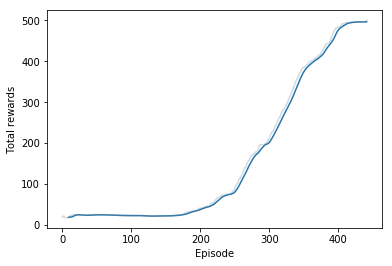

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

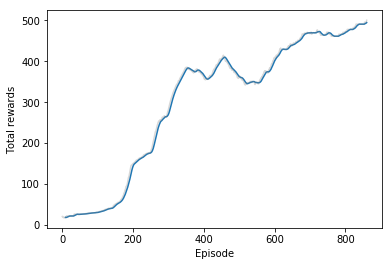

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

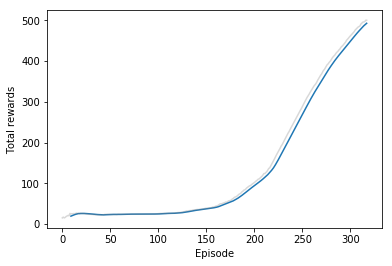

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

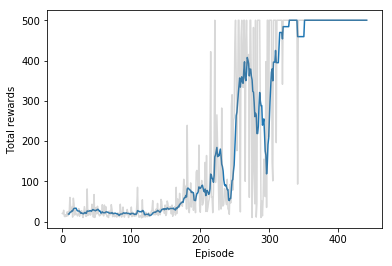

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

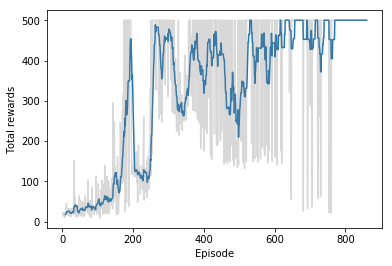

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

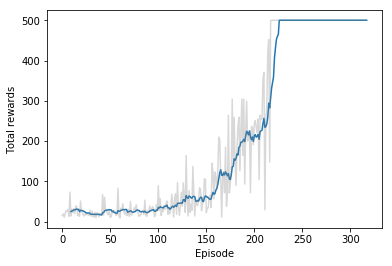

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

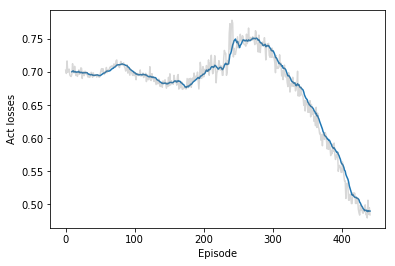

In [20]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

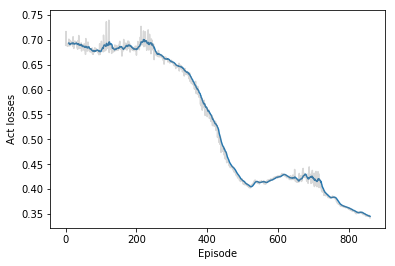

In [19]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

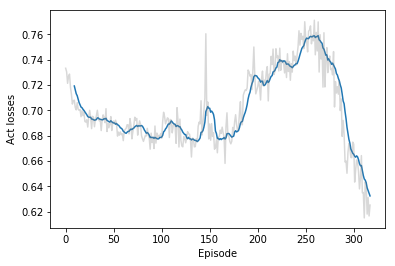

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

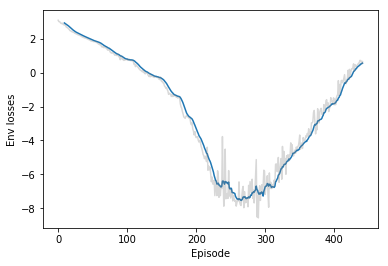

In [21]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

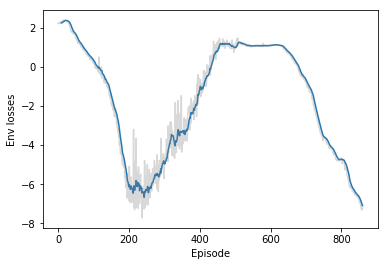

In [20]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

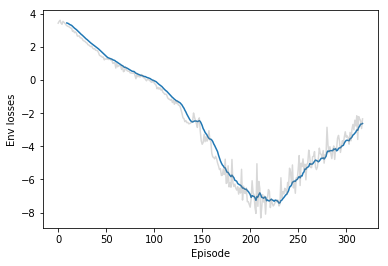

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

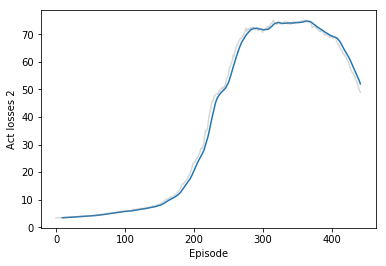

In [22]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

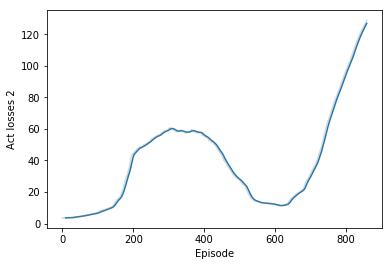

In [21]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

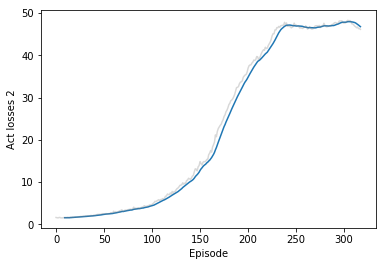

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
